In [10]:
from pydantic import BaseModel
from typing import List
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
import os

load_dotenv()

os.environ['LANGCHAIN_PROJECT'] = "travel-planner"


In [11]:
llm  = ChatOpenAI(temperature=0, model='gpt-4o-mini')

In [12]:
class AgentState(TypedDict):
    destination: str
    from_date: str
    to_date: str
    plan: str
    research_results: List[str]
    itinerary: str

In [13]:
PLANNER_PROMPT = """ You are an expert travel planner tasked with creating a high \
level itinerary outline.Write such an outline for the user provided \
destination and dates. Give an outline of the itinerary. """

RESEARCH_PLAN_PROMPT = """You are a travel planner tasked with finding events \
for a user visiting. Generate a list of search queries that will gather \
information on local events during this period such as music festivals, \
food fairs, technical conferences, or any other noteworthy events. \
Only generate 3 queries max."""

WRITER_PROMPT = """You are a travel agent tasked with creating the best \
possible travel itinerary for the user's trip. Generate a detailed itinerary \
based on the provided destination, dates, and any relevant information. \
If the user provides feedback or changes, respond with a revised version \
of your previous itinerary.\
Utilize all the information below as needed:

{content}
"""


In [14]:
def travel_plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLANNER_PROMPT),
        HumanMessage(content=f"Destination: {state['destination']}\n\n Dates: \n Start Date: {state['from_date']}\nEnd Date: {state['to_date']}")
    ]
    
    response = llm.invoke(messages).content
    
    return {"plan": response}
    
    

In [15]:



class Query(BaseModel):
    queries: List[str]


tavily_search_tool = TavilySearchResults()


def travel_research_node(state: AgentState):

    messages = [
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(
            content=f"Destination: {state['destination']}\n\n Dates: \n Start Date: {state['from_date']}\nEnd Date: {state['to_date']}"
        ),
    ]
    quiries = llm.with_structured_output(Query).invoke(messages)

    tavily_results = []

    for q in quiries.queries:
        tavily_responses = tavily_search_tool.invoke(q)

        for response in tavily_responses:
            tavily_results.append(response["content"])

    return {"research_results": tavily_results}




In [16]:
def generate_travel_itinerary(state: AgentState):
    research_result = "\n\n" .join(state['research_results'] or [])
    
    user_message = HumanMessage(
        content=f"Destination: {state['destination']}\n\n Dates: \n Start Date: {state['from_date']}\nEnd Date: {state['to_date']} \n\n\n Here is my plan: \n {state['plan']}"
    )
    
    
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=research_result)),
        user_message
    ]
    
    response = llm.invoke(messages).content
    
    return {"itinerary": response}

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node('travel_plan_node', travel_plan_node)
workflow.add_node('travel_research_node', travel_research_node)
workflow.add_node('generate_travel_itinerary', generate_travel_itinerary)

workflow.set_entry_point('travel_plan_node')
workflow.add_edge('travel_plan_node', "travel_research_node")
workflow.add_edge('travel_research_node', "generate_travel_itinerary")
workflow.add_edge('generate_travel_itinerary', END)


graph = workflow.compile()

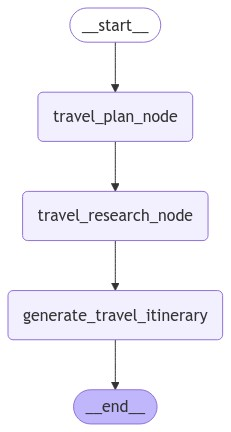

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
user_input = {
    'destination': 'Kenya, Nairobi',
    'from_date': '2024-10-21',
    'to_date': '2024-10-25'
}

response = graph.invoke(user_input)

In [30]:

print(response['itinerary'])

### Detailed Itinerary for Nairobi, Kenya  
**Dates: October 21, 2024 - October 25, 2024**

---

#### Day 1: Arrival in Nairobi  
**Date: October 21, 2024**  
- **Morning:**  
  - Arrive at Jomo Kenyatta International Airport (NBO)  
  - Transfer to your hotel (suggested: Sarova Panafric Hotel or similar) for check-in  
- **Afternoon:**  
  - **Lunch:** Enjoy a meal at **Carnivore Restaurant** known for its variety of meats or **Nyama Mama** for a modern twist on traditional Kenyan dishes.  
  - **Activity:** Visit the **Nairobi National Museum** (Entry Fee: KES 1,200) to explore Kenya's rich history and culture.  
- **Evening:**  
  - **Dinner:** Dine at **The View Restaurant** for stunning city views.  
  - **Optional:** Explore local nightlife at **K1 Klub House** or relax at the hotel.

---

#### Day 2: Nairobi City Tour  
**Date: October 22, 2024**  
- **Morning:**  
  - **Breakfast:** Enjoy a buffet breakfast at the hotel.  
  - **Activity:** Visit the **David Sheldrick Wildlife 